In [1]:
import os
import numpy as np
import numpy.random as rd
import scipy as sp
from scipy import stats as st
from collections import Counter

import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc
import matplotlib.animation as ani
plt.rcParams["patch.force_edgecolor"] = True
#rc('text', usetex=True)
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]
%matplotlib inline

# %config InlineBackend.figure_format='retina'
# OS判別 ======================
flag_win32 = False
try:
    os.uname()
except AttributeError:
    flag_win32 = True

# Mac用フォント設定
if not flag_win32:
    font_path = '/Library/Fonts/Osaka.ttf'
    font_prop = font_manager.FontProperties(fname=font_path)
    matplotlib.rcParams['font.family'] = font_prop.get_name()
    plt.rcParams['font.family'] = 'Osaka'


In [2]:
def calc_likelihood(data, mu, sigma, pi, K):
    likelihood = np.zeros((np.sum(n), 3))
    for k in range(K):
        likelihood[:, k] = [pi[k]*st.multivariate_normal.pdf(d, mu[k], sigma[k]) for d in data]
    return likelihood

def calc_prob_gmm(data, mu, sigma, pi, K):
    return [[pi[k]*st.multivariate_normal.pdf(d, mu[k], sigma[k]) for k in range(K)] for d in data]

def print_gmm_contour(mu, sigma, pi, K):
    # display predicted scores by the model as a contour plot
    X, Y = np.meshgrid(np.linspace(min_x, max_x), np.linspace(min_y, max_y))
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = np.sum(np.asanyarray(calc_prob_gmm(XX, mu, sigma, pi, K)), axis=1)
    Z = Z.reshape(X.shape)
    CS = plt.contour(X, Y, Z, alpha=0.2, zorder=-100)
    
    plt.title('pdf contour of a GMM')

check:  0 [ 0.2  0.5] [[ 0.1    0.085]
 [ 0.085  0.1  ]] 0.002775
check:  1 [ 1.2  0.5] [[ 0.1   -0.085]
 [-0.085  0.1  ]] 0.002775
check:  2 [ 2.   0.5] [[ 0.1    0.085]
 [ 0.085  0.1  ]] 0.002775


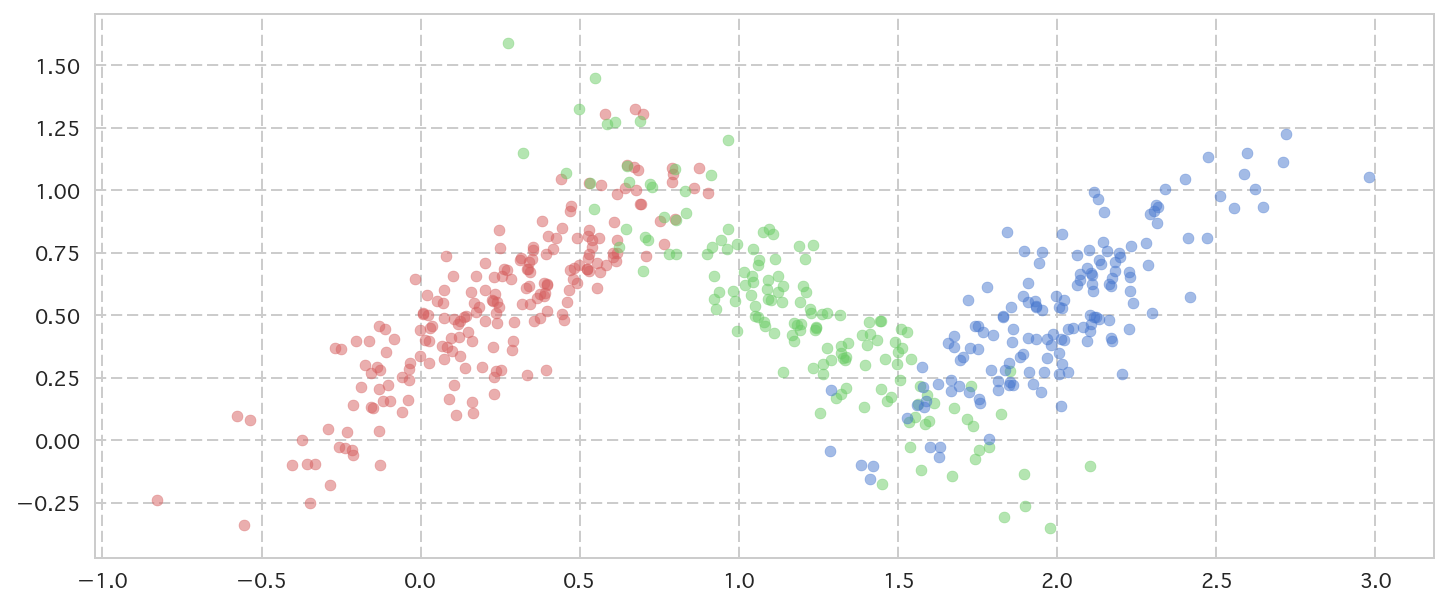

In [7]:
seed = 77
D = 2
n = [200, 150, 150]
N = np.sum(n)
mu_true = np.asanyarray(
     [[0.2, 0.5],
      [1.2, 0.5],
      [2.0, 0.5]])

D = mu_true.shape[1]

sigma_true = np.asanyarray(
        [ [[0.1,  0.085],[ 0.085, 0.1]],
          [[0.1, -0.085],[-0.085, 0.1]],
          [[0.1,  0.085],[ 0.085, 0.1]]
        ])
c = ['r', 'g', 'b']

rd.seed(seed)
org_data = None #np.empty((np.sum(n), 3))
for i in range(3):
    print("check: ", i, mu_true[i], sigma_true[i], np.linalg.det(sigma_true[i]))
    #org_data.append(st.multivariate_normal.rvs(mean=mu[i], cov=sigma[i], size=n[i]))
    if org_data is None:
        org_data = np.c_[st.multivariate_normal.rvs(mean=mu_true[i], cov=sigma_true[i], size=n[i]), np.ones(n[i])*i]
    else:
        org_data = np.r_[org_data, np.c_[st.multivariate_normal.rvs(mean=mu_true[i], 
                                                                    cov=sigma_true[i], 
                                                                    size=n[i]), np.ones(n[i])*i]]
        
# plot generated data        

plt.figure(figsize=(12, 5))
for i in range(3):
    plt.scatter(org_data[org_data[:,2]==i][:,0], org_data[org_data[:,2]==i][:,1], s=30, c=c[i], alpha=0.5)
    
# drop true cluster label
data = org_data[:,0:2].copy()

# Initialize

init pi: [ 0.33333333  0.33333333  0.33333333]
init mu:
 [[ 2.23461734  0.21275208]
 [ 0.603098    0.32835039]
 [-0.33165408  0.21129426]]


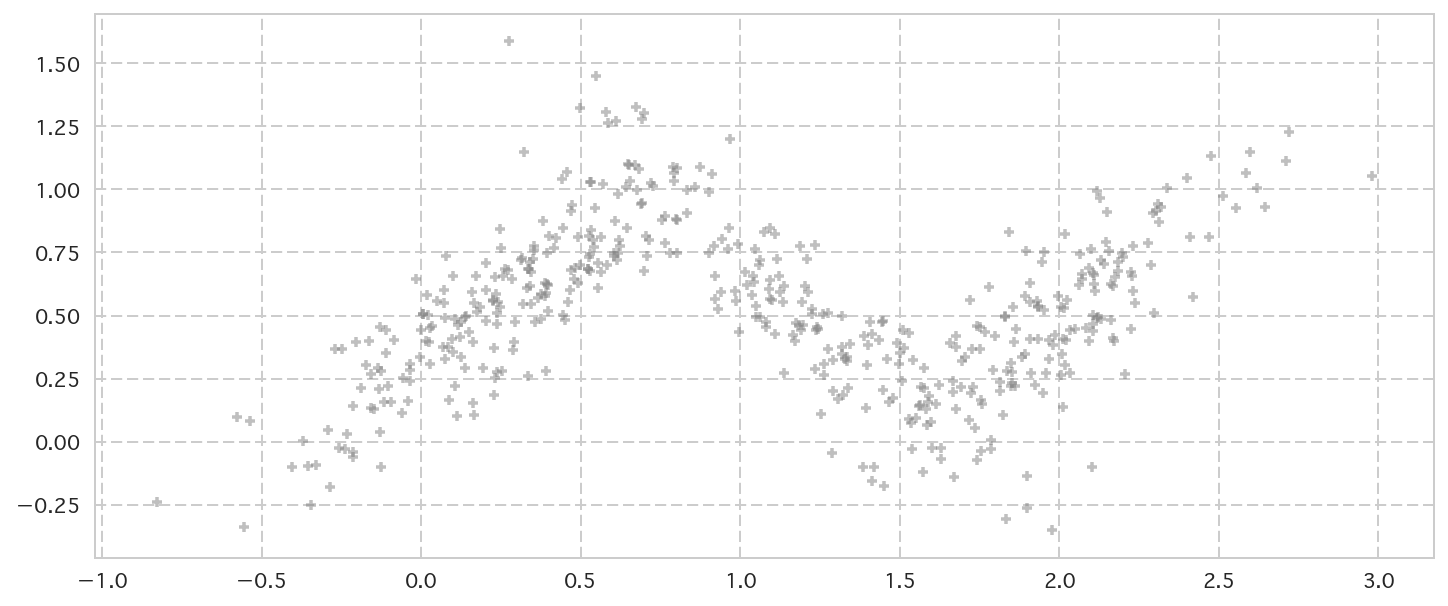

initial sum of log likelihood: -15959.1495777
pi:
 [ 0.33333333  0.33333333  0.33333333]
mu:
 [[ 2.23461734  0.21275208]
 [ 0.603098    0.32835039]
 [-0.33165408  0.21129426]]
sigma:
 [[[ 0.1  0. ]
  [ 0.   0.1]]

 [[ 0.1  0. ]
  [ 0.   0.1]]

 [[ 0.1  0. ]
  [ 0.   0.1]]]


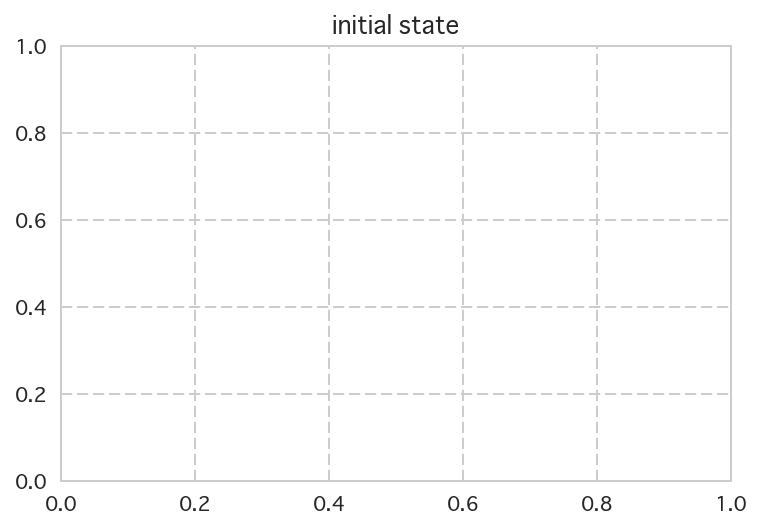

In [8]:

# initialize pi
K = 3
pi = np.zeros(K)
for k in range(K):
    if k == K-1:
        pi[k] = 1 - np.sum(pi)
    else:
        pi[k] = 1/K
print('init pi:', pi)

# initialize mu
max_x, min_x = np.max(data[:,0]), np.min(data[:,0])
max_y, min_y = np.max(data[:,1]), np.min(data[:,1])
mu = np.c_[rd.uniform(low=min_x, high=max_x, size=K), rd.uniform(low=min_y, high=max_y, size=K) ]
print('init mu:\n', mu)

# visualize for check
#plt.figure(figsize=(12,8))
plt.figure(figsize=(12, 5))
plt.scatter(data[:,0], data[:,1], s=30, c='gray', alpha=0.5, marker="+")

for i in range(3):
    plt.scatter([mu[i, 0]], [mu[i, 1]], c=c[i], marker='o')
    
plt.show()

# initialize sigma
sigma = np.asanyarray(
        [ [[0.1,  0],[ 0, 0.1]],
          [[0.1,  0],[ 0, 0.1]],
          [[0.1,  0],[ 0, 0.1]] ])

# calculate likelihood
likelihood = calc_likelihood(data, mu, sigma, pi, K)
print('initial sum of log likelihood:', np.sum(np.log(likelihood)))

print('pi:\n', pi)
print('mu:\n', mu)
print('sigma:\n', sigma)

plt.title('initial state')

# EM algorithm started

In [5]:
#for step in range(100):
def animate(nframe):
    global mu, sigma, pi
    print('nframe:', nframe)
    plt.clf()
    
    if nframe <= 3:
        print('initial state')
        plt.scatter(data[:,0], data[:,1], s=30, c='gray', alpha=0.5, marker="+")
        for i in range(3):
            plt.scatter([mu[i, 0]], [mu[i, 1]], c=c[i], marker='o', edgecolors='k', linewidths=1)
        print_gmm_contour(mu, sigma, pi, K)
        plt.title('initial state')
        return

    # E step ========================================================================
    # calculate responsibility(負担率)
    likelihood = calc_likelihood(data, mu, sigma, pi, K)
    #gamma = np.apply_along_axis(lambda x: [xx/np.sum(x) for xx in x] , 1, likelihood)
    gamma = (likelihood.T/np.sum(likelihood, axis=1)).T
    N_k = [np.sum(gamma[:,k]) for k in range(K)]

    # M step ========================================================================

    # caluculate pi
    pi =  N_k/N

    # calculate mu
    tmp_mu = np.zeros((K, D))

    for k in range(K):
        for i in range(len(data)):
            tmp_mu[k] += gamma[i, k]*data[i]
        tmp_mu[k] = tmp_mu[k]/N_k[k]
        #print('updated mu[{}]:\n'.format(k) , tmp_mu[k])
    mu_prev = mu.copy()
    mu = tmp_mu.copy()
    #print('updated mu:\n', mu)

    # calculate sigma
    tmp_sigma = np.zeros((K, D, D))

    for k in range(K):
        tmp_sigma[k] = np.zeros((D, D))
        for i in range(N):
            tmp = np.asanyarray(data[i]-mu[k])[:,np.newaxis]
            tmp_sigma[k] += gamma[i, k]*np.dot(tmp, tmp.T)
        tmp_sigma[k] = tmp_sigma[k]/N_k[k]

        #print('updated sigma[{}]:\n'.format(k) , tmp_sigma[k])
    sigma = tmp_sigma.copy()

    # calculate likelihood
    prev_likelihood = likelihood
    likelihood = calc_likelihood(data, mu, sigma, pi, K)
    
    prev_sum_log_likelihood = np.sum(np.log(prev_likelihood))
    sum_log_likelihood = np.sum(np.log(likelihood))
    diff = prev_sum_log_likelihood - sum_log_likelihood
    
    print('sum of log likelihood:', sum_log_likelihood)
    print('diff:', diff)

    print('pi:', pi)
    print('mu:', mu)
    print('sigma:', sigma)

    # visualize
    #plt.figure(figsize=(12,8))
    for i in range(N):
        plt.scatter(data[i,0], data[i,1], s=30, c=gamma[i], alpha=0.5, marker="+")

    for i in range(K):
        ax = plt.axes()
        ax.arrow(mu_prev[i, 0], mu_prev[i, 1], mu[i, 0]-mu_prev[i, 0], mu[i, 1]-mu_prev[i, 1],
                  lw=0.8, head_width=0.02, head_length=0.02, fc='k', ec='k')
        plt.scatter([mu_prev[i, 0]], [mu_prev[i, 1]], c=c[i], marker='o', alpha=0.8)
        plt.scatter([mu[i, 0]], [mu[i, 1]], c=c[i], marker='o', edgecolors='k', linewidths=1)
        #plt.scatter([mu[i, 0]], [mu[i, 1]], c=c[i], marker='o')
    plt.title("step:{}".format(nframe))
    
    print_gmm_contour(mu, sigma, pi, K)
    # plt.show()
    
    if np.abs(diff) < 0.0001:
        plt.title('likelihood is converged.')
    else:
        plt.title("iter:{}".format(nframe-3))

nframe: 0
initial state
nframe: 0
initial state
nframe: 1
initial state
nframe: 2
initial state
nframe: 3
initial state
nframe: 4
sum of log likelihood: -28949.449633
diff: 12990.3000553
pi: [ 0.37425622  0.47734472  0.14839906]
mu: [[ 1.92946957  0.43847159]
 [ 0.70882196  0.65462358]
 [-0.06626214  0.27555338]]
sigma: [[[ 0.09619612  0.07009194]
  [ 0.07009194  0.09716098]]

 [[ 0.16528261 -0.02062909]
  [-0.02062909  0.07833795]]

 [[ 0.05343443  0.04434765]
  [ 0.04434765  0.06405165]]]
nframe: 5
sum of log likelihood: -29483.2972551
diff: 533.847622106
pi: [ 0.37749335  0.44113755  0.18136909]
mu: [[ 1.92023766  0.42813651]
 [ 0.74611943  0.68041833]
 [-0.018653    0.30709161]]
sigma: [[[ 0.1010454   0.07561255]
  [ 0.07561255  0.09999275]]

 [[ 0.15974937 -0.02716048]
  [-0.02716048  0.07148596]]

 [[ 0.05744736  0.04716718]
  [ 0.04716718  0.06190521]]]
nframe: 6
sum of log likelihood: -28328.5588723
diff: -1154.73838277
pi: [ 0.37683523  0.40770899  0.21545578]
mu: [[ 1.9205736

nframe: 26
sum of log likelihood: -38831.2573642
diff: 0.0828657783131
pi: [ 0.31078877  0.29328398  0.39592725]
mu: [[ 1.99195339  0.49733757]
 [ 1.17044467  0.53905899]
 [ 0.22298478  0.51729046]]
sigma: [[[ 0.08604229  0.07103685]
  [ 0.07103685  0.08601515]]

 [[ 0.12168877 -0.11849156]
  [-0.11849156  0.13718312]]

 [[ 0.0998719   0.08195454]
  [ 0.08195454  0.09101055]]]
nframe: 27
sum of log likelihood: -38831.303207
diff: 0.0458428561542
pi: [ 0.31078861  0.29328196  0.39592942]
mu: [[ 1.99195361  0.49733784]
 [ 1.17044866  0.53905515]
 [ 0.22298719  0.5172932 ]]
sigma: [[[ 0.08604225  0.07103678]
  [ 0.07103678  0.08601506]]

 [[ 0.12168763 -0.11849069]
  [-0.11849069  0.13718238]]

 [[ 0.0998725   0.08195528]
  [ 0.08195528  0.09101154]]]
nframe: 28
sum of log likelihood: -38831.3285979
diff: 0.0253908744053
pi: [ 0.31078853  0.29328083  0.39593064]
mu: [[ 1.99195373  0.49733799]
 [ 1.17045087  0.53905302]
 [ 0.22298853  0.51729472]]
sigma: [[[ 0.08604223  0.07103674]
  [ 0.0

nframe: 0
initial state


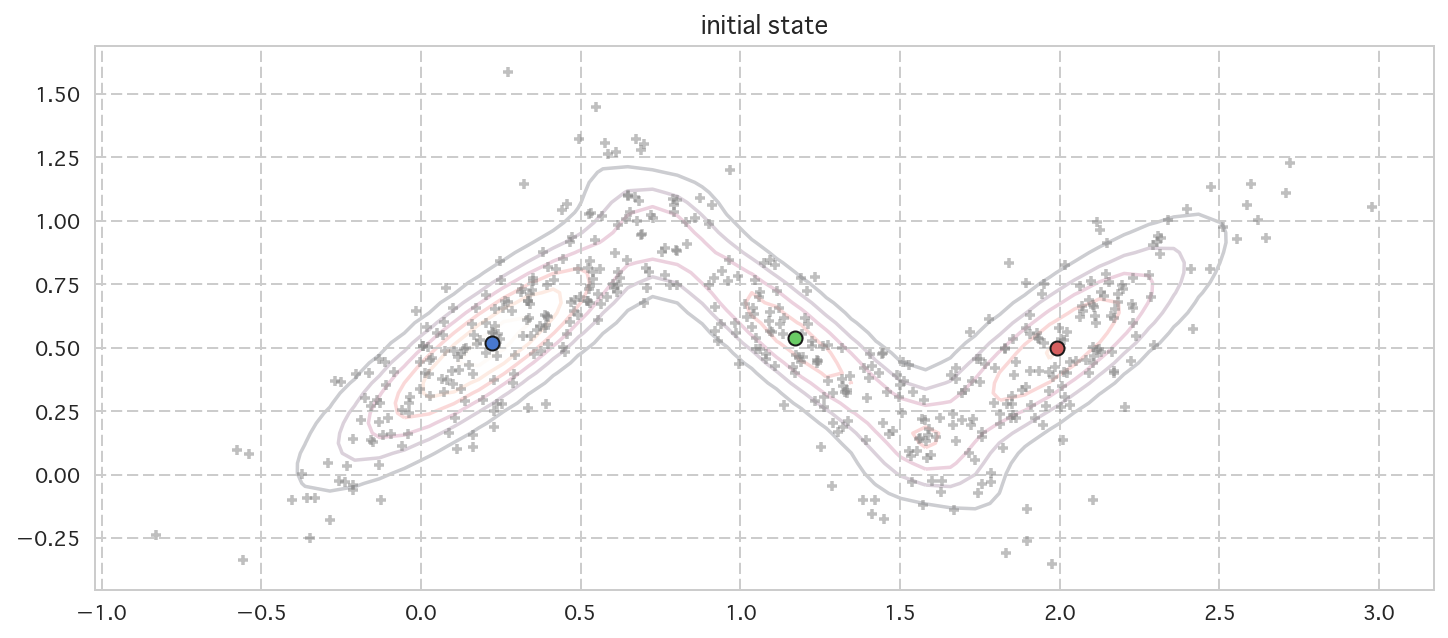

In [6]:
fig = plt.figure(figsize=(12,5))
anim = ani.FuncAnimation(fig, animate, frames=48)
anim.save('gmm_anim.gif', writer='imagemagick', fps=3, dpi=128)


array([[ 1.99195386,  0.49733816],
       [ 1.17045364,  0.53905035],
       [ 0.22299021,  0.51729664]])

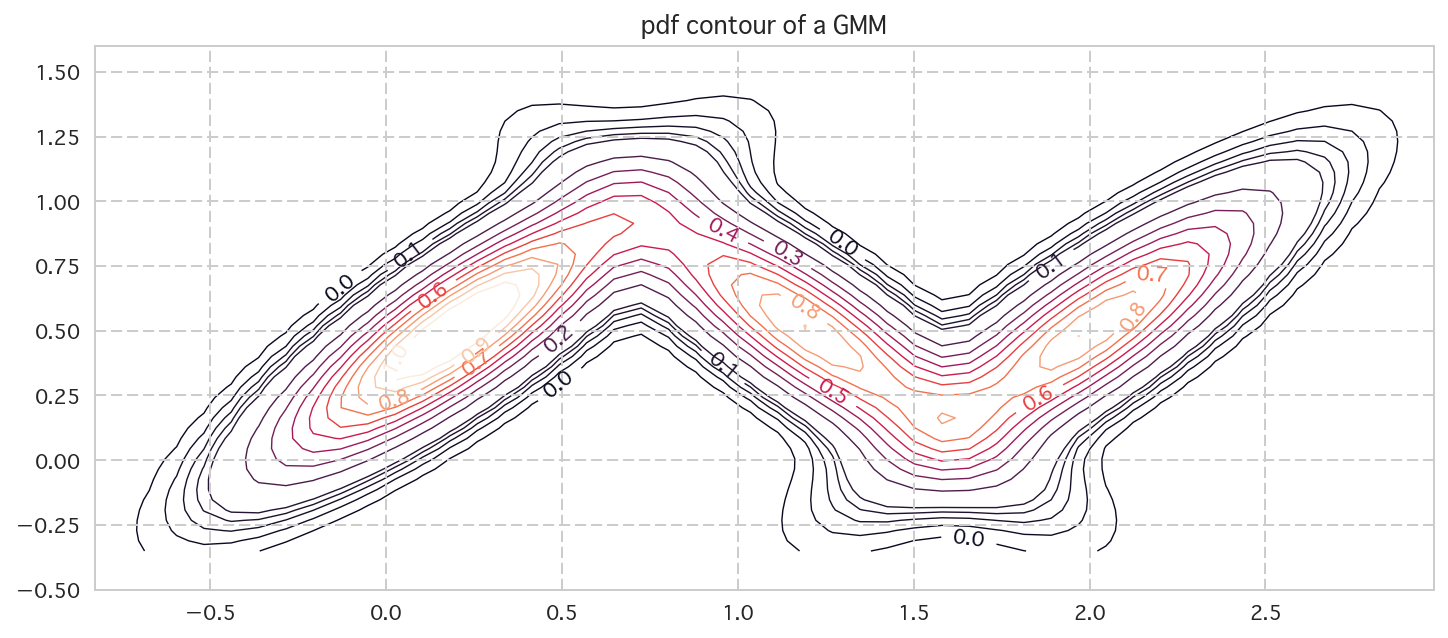

In [28]:
mu_true = np.asanyarray(
     [[0.2, 0.5],
      [1.2, 0.5],
      [2.0, 0.5]])

sigma_true = np.asanyarray(
        [ [[0.1,  0.085],[ 0.085, 0.1]],
          [[0.1, -0.085],[-0.085, 0.1]],
          [[0.1,  0.085],[ 0.085, 0.1]]
        ])


plt.figure(figsize=(12, 5))
X, Y = np.meshgrid(np.linspace(min_x, max_x), np.linspace(min_y, max_y))
XX = np.array([X.ravel(), Y.ravel()]).T
Z = np.sum(np.asanyarray(calc_prob_gmm(XX, mu_true, sigma_true, np.array(n)/N, K)), axis=1)
Z = Z.reshape(X.shape)
levels = np.r_[np.arange(0, 0.1, 0.02),np.arange(0.1, 1.1, 0.1)]
CS = plt.contour(X, Y, Z, alpha=1, zorder=-100, linewidths=0.7, levels=levels)#[0.2, 0.4, 0.8, 1.0])
CS.clabel(fmt='%1.1f', fontsize=10)
plt.ylim(-0.5, 1.6)
plt.title('pdf contour of a GMM')

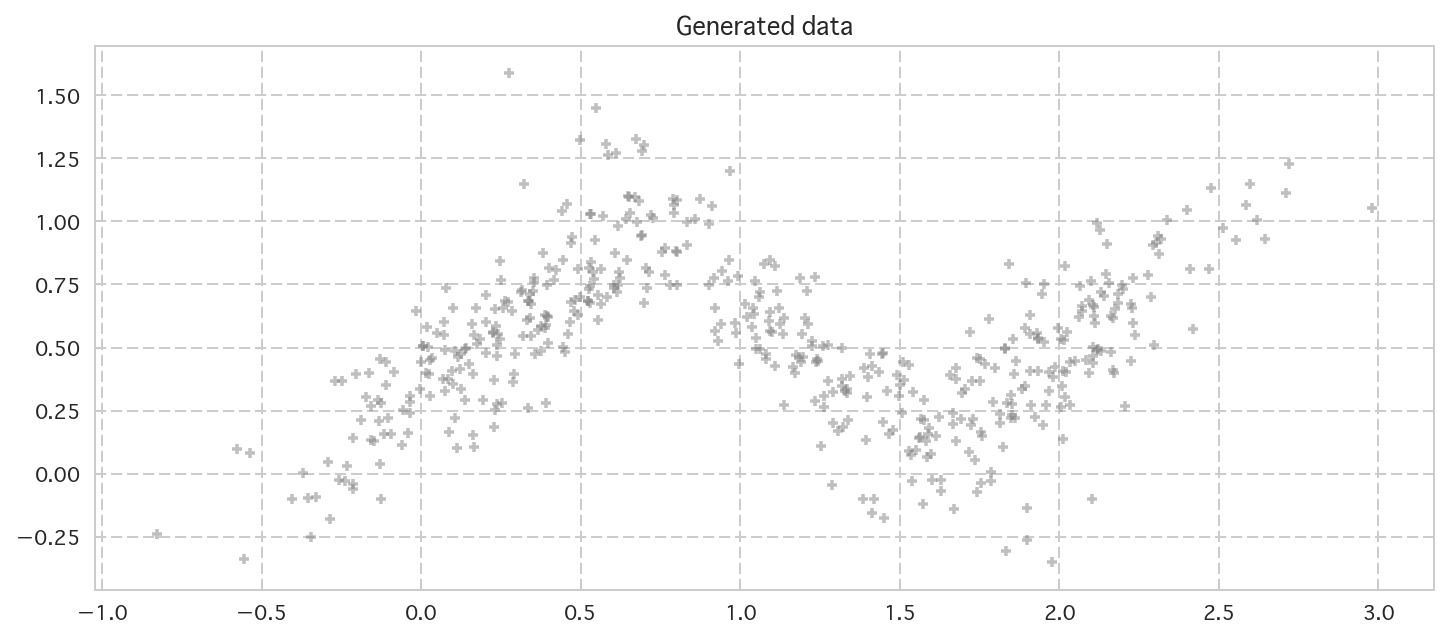

In [31]:

# visualize for check
plt.figure(figsize=(12, 5))
plt.scatter(data[:,0], data[:,1], s=30, c='gray', alpha=0.5, marker="+")
plt.title('Generated data')